In [1]:
import sys
import os

import pandas as pd

# add parent directory to path
library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

from cge_comrare_pipeline.AncestryQC import AncestryQC

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Create interactive widgets for input
input_path = widgets.Text(
    value='/home/luis/data/rawdata-sexupdated/outputData/sample_qc_results/clean_files',
    description='Path to input plink1.9 files:',
    style={'description_width': 'initial'}
)

input_name = widgets.Text(
    value='luxgiant_res-clean-samples',
    description='Name of the plink1.9 files:',
    style={'description_width': 'initial'}
)

dependables_path = widgets.Text(
    value='/home/luis/data/rawdata-sexupdated/dependables/',
    description='Path to dependable files:',
    style={'description_width': 'initial'}
)

output_path = widgets.Text(
    value='/home/luis/data/rawdata-sexupdated/outputData/',
    description='Path to output files:',
    style={'description_width': 'initial'}
)
output_name = widgets.Text(
    value='luxgiant_res',
    description='Name of the resulting files:',
    style={'description_width': 'initial'}
)
# Display the widgets
display(input_path, input_name, dependables_path, output_path, output_name)

# Function to get the text parameter values
def get_params():
    return input_path.value, input_name.value, dependables_path.value, output_path.value, output_name.value

Text(value='/home/luis/data/rawdata-sexupdated/outputData/sample_qc_results/clean_files', description='Path to…

Text(value='luxgiant_res-clean-samples', description='Name of the plink1.9 files:', style=TextStyle(descriptio…

Text(value='/home/luis/data/rawdata-sexupdated/dependables/', description='Path to dependable files:', style=T…

Text(value='/home/luis/data/rawdata-sexupdated/outputData/', description='Path to output files:', style=TextSt…

Text(value='luxgiant_res', description='Name of the resulting files:', style=TextStyle(description_width='init…

In [3]:
# Create interactive widgets for list input
ind_par = widgets.Textarea(
    value='50, 5, 0.2',
    description='indep pairwise (comma-separated):',
    style={'description_width': 'initial'}
)

maf = widgets.FloatText(
    value=0.01,  # Default value
    description='maf (float):',
    style={'description_width': 'initial'}
)

pca = widgets.IntText(
    value=10,  # Default value
    description='mind (float):',
    style={'description_width': 'initial'}
)

ref_threshold = widgets.FloatText(
    value=4,  # Default value
    description='threshold for the deviations from the mean on reference panel:',
    style={'description_width': 'initial'}
)

stu_threshold = widgets.FloatText(
    value=4,  # Default value
    description='threshold for the deviations from the mean on study population:',
    style={'description_width': 'initial'}
)

num_pcs = widgets.IntText(
    value=2,  # Default value
    description='Number of PCs to determine a sample outlier status:',
    style={'description_width': 'initial'}
)

# display the widgets
display(ind_par, maf, pca, stu_threshold, ref_threshold, num_pcs)

def get_ancestry_qc_params():

    ancestry_qc_params = dict()

    indep = ind_par.value.split(',')

    ancestry_qc_params['maf'] = maf.value
    ancestry_qc_params['indep'] = [int(indep[0]), int(indep[1]), float(indep[2])]
    ancestry_qc_params['pca'] = pca.value
    ancestry_qc_params['ref_threshold'] = ref_threshold.value
    ancestry_qc_params['stu_threshold'] = stu_threshold.value
    ancestry_qc_params['num_pcs'] = num_pcs.value

    return ancestry_qc_params

Textarea(value='50, 5, 0.2', description='indep pairwise (comma-separated):', style=TextStyle(description_widt…

FloatText(value=0.01, description='maf (float):', style=DescriptionStyle(description_width='initial'))

IntText(value=10, description='mind (float):', style=DescriptionStyle(description_width='initial'))

FloatText(value=4.0, description='threshold for the deviations from the mean on study population:', style=Desc…

FloatText(value=4.0, description='threshold for the deviations from the mean on reference panel:', style=Descr…

IntText(value=2, description='Number of PCs to determine a sample outlier status:', style=DescriptionStyle(des…

In [4]:
ancestry_params = get_ancestry_qc_params()
ancestry_params

{'maf': 0.01,
 'indep': [50, 5, 0.2],
 'pca': 10,
 'ref_threshold': 4.0,
 'stu_threshold': 4.0,
 'num_pcs': 2}

In [5]:
ancestry = AncestryQC(
    input_path      =input_path.value,
    input_name      =input_name.value,
    output_path     =output_path.value,
    output_name     =output_name.value,
    dependables_path=dependables_path.value,
)

find samples with discordant ancestry.
generate PCA plot.


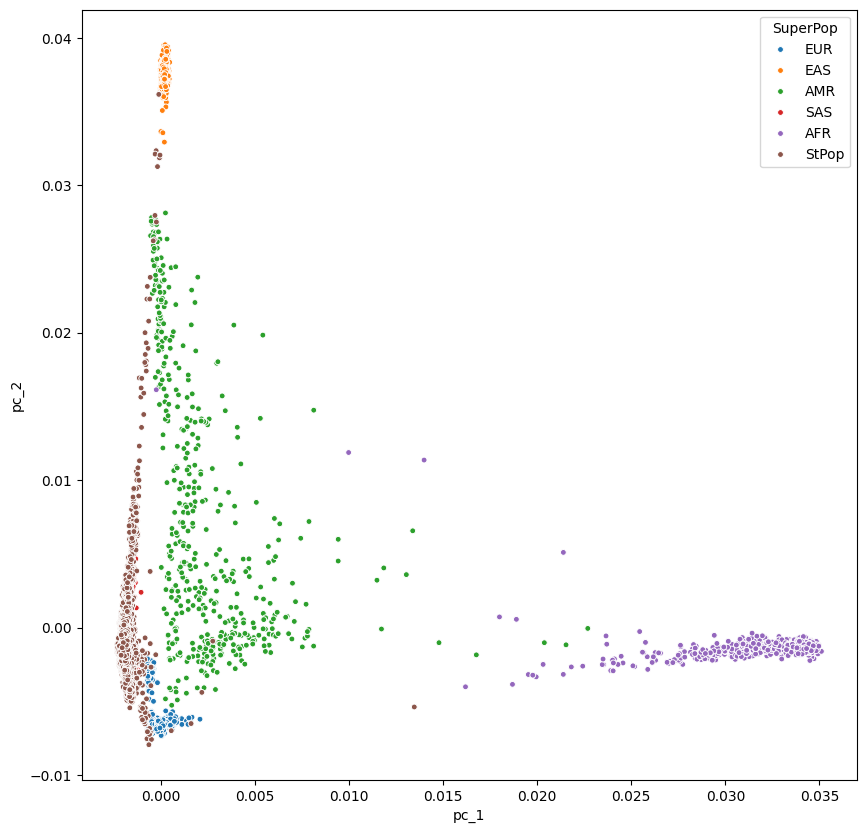

In [ ]:
ancestry_qc_steps = {
    'filter_snps'              : (ancestry.execute_filter_prob_snps, ()),
    'LD_pruning'               : (ancestry.execute_ld_pruning, (ancestry_params['indep'],)),
    'reference_pruning'        : (ancestry.execute_ld_prune_ref_panel, ()),
    'chr_missmatch'            : (ancestry.execute_fix_chromosome_missmatch,()),
    'pos_missmatch_allele_flip': (ancestry.execute_fix_position_missmatch_allele_flip, ()),
    'remove_missmatch'         : (ancestry.execute_remove_missmatch, ()),
    'merging'                  : (ancestry.execute_merge_ref_study, ()),
    'pca_analysis'             : (ancestry.execute_pc_decomposition, (ancestry_params['pca'], ancestry_params['maf'],)),
    'get_outliers'             : (ancestry.get_ancestry_outliers, (ancestry_params['ref_threshold'], ancestry_params['stu_threshold'], 'SAS', ancestry_params['num_pcs'],)),
    'pca_plot'                 : (ancestry.pca_plot, ())
}

step_description = {
    'filter_snps'              : 'filter problematic snps',
    'LD_pruning'               : 'LD prune study_population',
    'reference_pruning'        : 'LD prune reference panel',
    'chr_missmatch'            : 'fix any chromosome missmatch',
    'pos_missmatch_allele_flip': 'fix any issue with position missmatch and allele flip',
    'remove_missmatch'         : 'remove missmatchesd SNPs',
    'merging'                  : 'merge reference panel and study population',
    'pca_analysis'             : 'execute PC decomposition',
    'get_outliers'             : 'find samples with discordant ancestry',
    'pca_plot'                 : 'generate PCA plot'
}

for name, (func, params) in ancestry_qc_steps.items():
    print(f"\033[1m{step_description[name]}.\033[0m")
    func(*params)